In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 8'

# QE band structure of GaAs (without SO interaction)

We build the band structure og GaAs without SO interaction

## SCF calculation : convergence of the GS energy

As usual we perform a convergence procedure based on the total energy of the GS to fix the converged value of the cut-off energy and of the number of kpoints for the GS density

In [3]:
input = I.PwIn()
Ga = [0.,0.,0.]
As = [0.25,0.25,0.25]

input.set_pseudo_dir('../pseudos')
input.set_calculation('scf')

input.set_occupations('fixed')
input.system['ibrav'] = 2
input.system['celldm(1)'] = 10.677
input.set_atoms_type(2)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='crystal',pos_list=[['Ga',Ga],['As',As]])
input.atypes = {'Ga': [69.72,'Ga_hamlu.fhi.UPF'],\
                'As': [74.92,'As_hamlu.fhi.UPF']}
input.set_convergence_thr(1e-8)

#print(input)

In [4]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 8 pw.x


In [5]:
gs_study = D.Dataset(label='gs_convergence',run_dir='GaAs_gs_convergence',pre_processing='scf')

In [6]:
gs_study.pre_processing_function()

Folder GaAs_gs_convergence already exists


In [7]:
kpoints = [2,3,4,5,6] 
ecut = [10,20,30,40,50]

In [8]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.set_prefix(D.name_from_id(idd))
        input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
        input.set_energy_cutoff(e)
        gs_study.append_run(id=idd,calculator=code,input=input)

In [9]:
gs_study.run(post_processing=True)

skip the computation for : ecut:10,k:2.log
parse file : GaAs_gs_convergence/ecut:10,k:2.save/data-file-schema.xml
skip the computation for : ecut:20,k:2.log
parse file : GaAs_gs_convergence/ecut:20,k:2.save/data-file-schema.xml
skip the computation for : ecut:30,k:2.log
parse file : GaAs_gs_convergence/ecut:30,k:2.save/data-file-schema.xml
skip the computation for : ecut:40,k:2.log
parse file : GaAs_gs_convergence/ecut:40,k:2.save/data-file-schema.xml
skip the computation for : ecut:50,k:2.log
parse file : GaAs_gs_convergence/ecut:50,k:2.save/data-file-schema.xml
skip the computation for : ecut:10,k:3.log
parse file : GaAs_gs_convergence/ecut:10,k:3.save/data-file-schema.xml
skip the computation for : ecut:20,k:3.log
parse file : GaAs_gs_convergence/ecut:20,k:3.save/data-file-schema.xml
skip the computation for : ecut:30,k:3.log
parse file : GaAs_gs_convergence/ecut:30,k:3.save/data-file-schema.xml
skip the computation for : ecut:40,k:3.log
parse file : GaAs_gs_convergence/ecut:40,k:3.

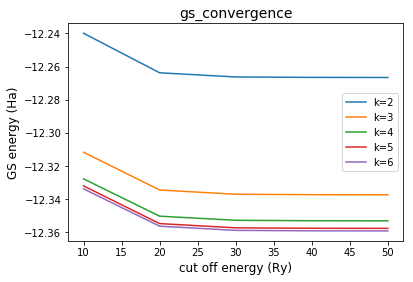

In [10]:
for k in kpoints:
    data=gs_study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(gs_study.label,size = 14)
plt.xlabel('cut off energy (Ry)',size=12)
plt.ylabel('GS energy (Ha)',size = 12)
plt.legend()
plt.show()

On this basis of this analysis we choose the converged parameters

In [11]:
k_conv = 6
ecut_conv = 50

## NSCF calculation : computation of the band structure

We compute the band structure of the GaAs with the aim to determine the feature of the X, Gamma and L valleys
that are relevant for the subsequent pump and probe analysis. 

Define a dictionary with the position of the high symmetry points of the GaAs lattice

In [12]:
G = [0.,0.,0.]
X = [1.,0.,0.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
#K = [0.75,0.75,0.]
high_sym = {'X':X,'L':L,'G':G,'W':W}

Bands are computed along the following path

In [13]:
numBands = 8
numStep = [30]
klist = [L+numStep,G+numStep,X+numStep,W+[0]]

In [14]:
bnds_study = D.Dataset(label='bands',run_dir='GaAs_bands',pre_processing='nscf')

Append the chosen bands computations to the dataset. Note that in this case we are performing just one computation. We are free to choose the idd as we want since there is no need to be able to discriminate among various results. For the prefix we always need to choose D.name_from_id(idd) to have the .save folder with the correct name.

In [15]:
input.set_calculation('nscf')
input.system['nbnd'] = numBands
idd = {'nbnd' : numBands}
input.set_prefix(D.name_from_id(idd))
input.set_energy_cutoff(ecut_conv)
input.set_kpoints(ktype='tpiba_b',klist=klist)

bnds_study.append_run(id=idd,calculator=code,input=input)

Call the pre_processing function

In [16]:
bnds_study.pre_processing_function(source_dir='GaAs_gs_convergence/ecut:50,k:6.save')

Folder GaAs_bands already exists
nscf save folder already exsists. Source GaAs_gs_convergence/ecut:50,k:6.save NOT COPIED


Run the dataset and extract the results of the (only) computation

In [17]:
bnds_study.run(post_processing=True)

execute : cd GaAs_bands ; OMP_NUM_THREADS=1 mpirun -np 8 pw.x -inp nbnd:8.in > nbnd:8.log
parse file : GaAs_bands/nbnd:8.save/data-file-schema.xml


Get the band structure

No handles with labels found to put in legend.


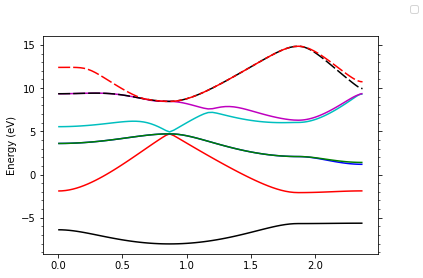

In [18]:
results = bnds_study.results[0]
bands = results.band_structure()

Plot the relevant band and identify the position of the high symmetry points on the path.

We use kpoints_cart.tolist() to add the position on the path to the high_sym dictionary

In [19]:
k_values = bands[:,0] # position on the path
kpoints_cart = results.kpt_cart # cartesian position for each value on the path
positions = []
labels = []
for point in high_sym:
    index = kpoints_cart.tolist().index(high_sym[point])
    labels.append(point)
    positions.append(k_values[index])

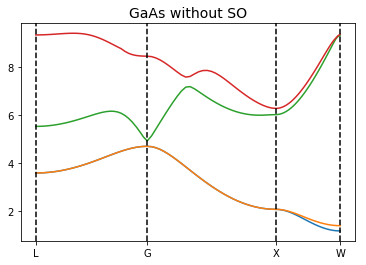

In [20]:
plotted_bands = [3,4,5,6]
for b in plotted_bands:
    plt.plot(k_values,bands[:,b])

for pos in positions:
    plt.axvline(pos,color='black',ls='--')

ax = plt.gca() # grab the current axis
ax.set_xticks(positions) # choose which x locations to have ticks
ax.set_xticklabels(labels) # set the labels to display at those ticks
plt.title('GaAs without SO',size = 14)

plt.show()

We compute the values of the gap in correspondence of the high symmetry points

In [21]:
for lb, pos in zip(labels,positions):
    gap = bands[:,5][k_values.tolist().index(pos)]-bands[:,4][k_values.tolist().index(pos)]
    print('gap in',lb,' = %.3f'%gap)

gap in X  = 3.949
gap in L  = 1.942
gap in G  = 0.226
gap in W  = 7.914
